In [1]:
from typing import List, Dict

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import *
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import itertools

from dcurves import dca, plot_graphs


In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)

In [3]:

processed_data = convert_numeric_to_float16(processed_data)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

In [4]:
cv_analytics_utils: Dict[str, CvAnalyticsUtil] = {}

In [5]:

# https://xgboost.readthedocs.io/en/latest/parameter.html
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier_entropy': RandomForestClassifier(criterion= 'entropy', n_estimators= 200), # Best one
    'RandomForestClassifier': RandomForestClassifier(criterion='entropy', n_estimators=300), # Best one
    # 'RandomForestClassifier_log_loss': RandomForestClassifier(criterion= 'log_loss', n_estimators= 300),
    # 'RandomForestClassifier_gini': RandomForestClassifier(criterion= 'gini', n_estimators= 300),
    # 'XGBClassifier_error': XGBClassifier(eval_metric= 'error', learning_rate=0.1),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'logloss', learning_rate=0.1), # Best one
    # 'XGBClassifier_rmsle': XGBClassifier(objective='binary:logistic', eval_metric= 'rmsle', learning_rate=0.1),
    # 'XGBClassifier_rmse': XGBClassifier(objective='binary:logistic', eval_metric= 'rmse', learning_rate=0.1),
    # 'XGBClassifier_mae': XGBClassifier(objective='binary:logistic', eval_metric= 'mae', learning_rate=0.1),
    # 'XGBClassifier_mape': XGBClassifier(objective='binary:logistic', eval_metric= 'mape', learning_rate=0.1),
    # 'XGBClassifier_aucpr': XGBClassifier(eval_metric= 'aucpr', learning_rate=0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    # ExperimentDataHelperSingleLabelScreenedCA125First5, # 1
    # ExperimentDataHelperSingleLabelScreenedUltraFirst5, # 1
    ExperimentDataHelperSingleLabelScreenedFirst5, # None, 1, 3, 5, 10
    # ExperimentDataHelperScreenedFirst5, # 1
    # ExperimentDataHelperSingleLabelNotScreenedColsFirst5, # None, 1
    # ExperimentDataHelperScreenedColsFirst5, # 1
    # ExperimentDataHelperScreened, # 1
    # ExperimentDataHelperSingleLabelNotScreenedCols, # None, 1
    # ExperimentDataHelperAll, # None, 1
    # ExperimentDataHelperScreenedFirst5ca125AndBinary, # 1
    # ExperimentDataHelperScreenedFirst5ca125Binary, # 1
]

experiment_over_labels: Dict[str, List] = {
    ExperimentDataHelperSingleLabelScreenedCA125First5.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelScreenedUltraFirst5.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelScreenedFirst5.get_name(): [1], # None, 1, 3, 5, 10
    ExperimentDataHelperScreenedFirst5.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelNotScreenedColsFirst5.get_name(): [None, 1], # None, 1
    ExperimentDataHelperScreenedColsFirst5.get_name(): [1], # 1
    ExperimentDataHelperScreened.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelNotScreenedCols.get_name(): [None, 1], # None, 1
    ExperimentDataHelperAll.get_name(): [None, 1], # None, 1
    ExperimentDataHelperScreenedFirst5ca125AndBinary.get_name(): [1], # 1
    ExperimentDataHelperScreenedFirst5ca125Binary.get_name(): [1], # 1
}

In [6]:
num_folds=1
test_n_folds=1
train_size = 25000
# [None, 25, 35, 50, 75, 100]
top_k_features = [50]
for classifier_name, classifier in classifiers.items():
    for experiment_data_helper_class in experiment_data_helpers:
        for top_k in top_k_features:
            for year in experiment_over_labels[experiment_data_helper_class.get_name()]:
                if year:
                    label = f'cancer_in_next_{year}_years'
                else: 
                    label = 'ovar_cancer'
                filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_{label}__{num_folds}_trials'
                select_cols = None
                if top_k:
                    select_cols = feature_importance_reader(filesuffix)[:top_k]
                    filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_top_{top_k}_features_{classifier_name}_{label}__{num_folds}_trials'
                print(filesuffix)
                # print(select_cols)
                experiment_data_helper: ExperimentDataHelper = experiment_data_helper_class(processed_data, label, ['cancer_'], train_size = train_size, select_features=select_cols)
                # experiment_data_helper.set_train_size_to_max(num_folds)
                experiment_runner = ExperimentRunner(classifier, experiment_data_helper, num_folds=num_folds, test_n_folds=test_n_folds)
                cv_analytics_util = experiment_runner.run_experiment()
                cv_analytics_utils[filesuffix] = cv_analytics_util
                cv_analytics_util.store_cv_analytics_utils(filesuffix)


_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__1_trials


In [7]:
sorted_df = experiment_data_helper.source_df.sort_values(by=['plco_id'])

In [8]:
def find_different_cols(df):
    return df.columns[df.nunique() > 1]

def extract_subrecords(plco_id):
    df = sorted_df[sorted_df['plco_id'].isin([plco_id])]
    return df[find_different_cols(df)]

In [9]:
plco_ids = ['A-001979-6', 'A-002879-7']

print_df(extract_subrecords(plco_ids[0]))

+----+-----------------+----------+----------+---------+-------------+-----------+-----------+---------------------+---------------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+----------------+----------------+--------------+---------------+---------------+-------------+-----------+-----------+------------+-----------+--------------+-----------+-----------+--------+--------+
|    |   ca125ii_level |   detl_p |   detr_p |   index |   lantero_p |   llong_p |   ltran_p |   ovar_observe_year |   ovar_result |   ovary_diam |   ovary_diaml |   ovary_diamr |   ovary_vol |   ovary_voll |   ovary_volr |   ovcyst_diam |   ovcyst_diaml |   ovcyst_diamr |   ovcyst_vol |   ovcyst_voll |   ovcyst_volr |   rantero_p |   rlong_p |   rtran_p |   study_yr |   tvu_ref |   tvu_result |   visboth |   viseith |   visl |   visr |
|----+-----------------+----------+----------+---------+-------------+-----------+-----------+---------------------+--

In [10]:
experiment_data_helper.source_df

,plco_id,bmi_20,bmi_50,bmi_curr,brothers,ca125_result,ca125ii_level,ca125ii_level_binary,cancer_in_next_1_years,cig_years,...,tvu_result,visboth,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f
0,A-001979-6,19.656250,28.34375,31.171875,2.0,1.0,12.0,1.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,NaN,1.0,104.0,150.0,165.0
1,A-001979-6,19.656250,28.34375,31.171875,2.0,1.0,12.0,1.0,0.0,0.0,...,3.0,1.0,1.0,1.0,1.0,NaN,1.0,104.0,150.0,165.0
2,A-001979-6,19.656250,28.34375,31.171875,2.0,1.0,11.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,104.0,150.0,165.0
3,A-001979-6,19.656250,28.34375,31.171875,2.0,1.0,15.0,1.0,0.0,0.0,...,3.0,0.0,1.0,0.0,1.0,NaN,1.0,104.0,150.0,165.0
4,A-001979-6,19.656250,28.34375,31.171875,2.0,1.0,11.0,1.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,NaN,1.0,104.0,150.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150753,Z-162169-9,19.921875,29.68750,31.250000,1.0,1.0,12.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,NaN,1.0,102.0,152.0,160.0
150754,Z-162169-9,19.921875,29.68750,31.250000,1.0,1.0,14.0,1.0,0.0,0.0,...,3.0,1.0,1.0,1.0,1.0,NaN,1.0,102.0,152.0,160.0
150755,Z-162169-9,19.921875,29.68750,31.250000,1.0,1.0,9.0,1.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,NaN,1.0,102.0,152.0,160.0
150756,Z-162169-9,19.921875,29.68750,31.250000,1.0,1.0,9.0,1.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,NaN,1.0,102.0,152.0,160.0


In [11]:
for analytics_util in cv_analytics_util.analytics_utils: 
    print(analytics_util.get_report_generation_util().get_roc_threshold())

0.56


In [12]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     filepath = f'./trees/decision_tree_for_{key}.png'
#     cv_analytics_util.analytics_utils[0].plot_save_tree(False, filepath)

In [13]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.store_cv_results()

_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__1_trials: 


Cross-Validation measures:
+--------------------+--------+-------+-------+-------+
|                    |   mean |   std |   min |   max |
|--------------------+--------+-------+-------+-------|
| precision__class_0 |      1 |   nan |     1 |     1 |
| recall__class_0    |      1 |   nan |     1 |     1 |
| f1-score__class_0  |      1 |   nan |     1 |     1 |
| precision__class_1 |      1 |   nan |     1 |     1 |
| recall__class_1    |      1 |   nan |     1 |     1 |
| f1-score__class_1  |      1 |   nan |     1 |     1 |
| accuracy           |      1 |   nan |     1 |     1 |
| auc                |      1 |   nan |     1 |     1 |
+--------------------+--------+-------+-------+-------+


In [14]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     cv_analytics_util.update_thresholds(None)
#     cv_analytics_util.get_cv_report();
#     cv_analytics_util.display_graph()

In [15]:

for filesuffix, cv_analytics_util in cv_analytics_utils.items():
    label = cv_analytics_util.get_label()
    if 'single' in filesuffix:
        cv_analytics_util.merge_in_dataset(get_screened_first_5_no_process_dataset(label = label))

Added new records: 190


In [16]:
for year in [None, 1, 3, 5, 10]:
    if year:
        label = f'cancer_in_next_{year}_years'
    else: 
        label = 'ovar_cancer'
    selected_cv_utils = {key: cv_analytics_util for key, cv_analytics_util in cv_analytics_utils.items() if cv_analytics_util.get_label() == label}
    if len(selected_cv_utils) == 0:
        continue
    intersecting_indexes = get_intersecting_indexes(selected_cv_utils)
    for filesuffix, cv_analytics_util in cv_analytics_utils.items():
        if cv_analytics_util.get_label() == label:
            cv_analytics_util.keep_indexes(intersecting_indexes)

_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__1_trials
Number of records: 150948
Number of indersecting indexes: 150948


_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__1_trials: 
[-0.0001, 0.624, 0.6566666666666666, 0.672, 0.7266666666666667, 1]
Threshold: 0.56


Cross-Validation measures:
+--------------------+----------+-------+----------+----------+
|                    |     mean |   std |      min |      max |
|--------------------+----------+-------+----------+----------|
| precision__class_0 | 0.999993 |   nan | 0.999993 | 0.999993 |
| recall__class_0    | 1        |   nan | 1        | 1        |
| f1-score__class_0  | 0.999997 |   nan | 0.999997 | 0.999997 |
| precision__class_1 | 1        |   nan | 1        | 1        |
| recall__class_1    | 0.991071 |   nan | 0.991071 | 0.991071 |
| f1-score__class_1  | 0.995516 |   nan | 0.995516 | 0.995516 |
| accuracy           | 0.999993 |   nan | 0.999993 | 0.999993 |
| auc                | 1        |   nan | 1        | 1        |
+--------------------+----------+-------+----------+-----

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


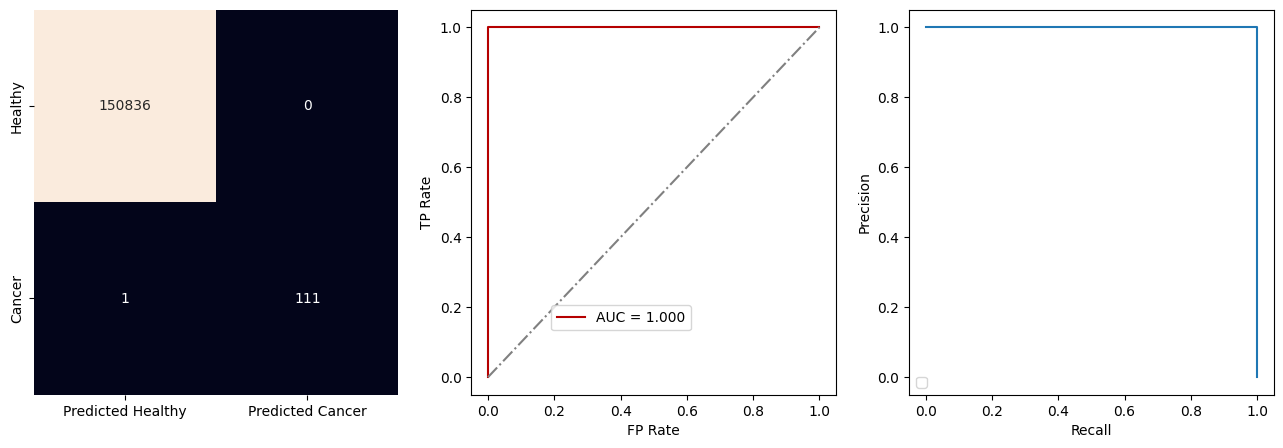

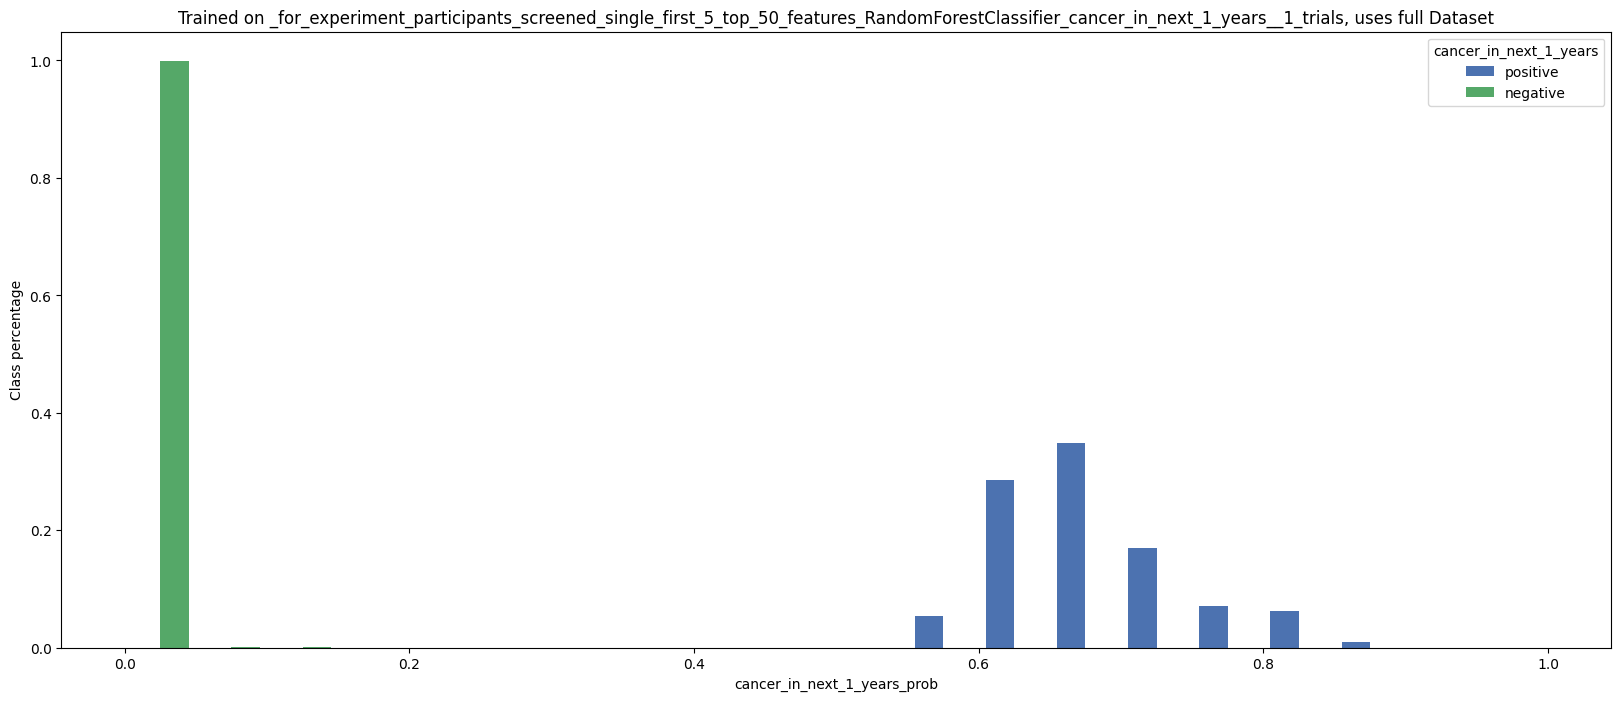

In [17]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    # Predicting actual cancer probability using bucketing
    per_thereshold_metrics = bucket_predictions_by_thresholds(cv_analytics_util)

    # General Plots
    threshold = cv_analytics_util.get_optimal_operating_point()
    # threshold = per_thereshold_metrics.loc[1, 'Threshold']
    print(f"Threshold: {threshold}")
    cv_analytics_util.update_thresholds(threshold)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    label = cv_analytics_util.get_label()
    full_dataset = cv_analytics_util.get_dataset_with_predictions()
    plot_hist_side_by_side_for_class(full_dataset, label, f'{label}_prob', normalize = True, title=f'Trained on {filesuffix}, uses full Dataset')